In [ ]:
from lle import LLE, ObservationType
import marl
from marl import Experiment, Runner
from marlenv import Episode

env = LLE.level(6).state_type(ObservationType.NORMALIZED_STATE).builder().time_limit(78).build()
agent = marl.agents.RandomAgent(env)

def get_trajectories(exp: Experiment, time_step: int):
    res = []
    for i, run in enumerate(exp.runs):
        seed = Runner.get_test_seed(time_step, 0)
        res.append((run.seed, exp.replay_episode(i, time_step, seed).episode))
    res = sorted(res, key=lambda x: x[0])
    return [x[1] for x in res]

# Generate trajectories

In [2]:
episodes = dict[str, list[Episode]]()

## Random agent

In [3]:
res = []
for i in range(30):
    obs, state = env.reset()
    is_terminal = False
    episode = Episode.new(obs, state)
    while not is_terminal:
        action = agent.choose_action(obs)
        step = env.step(action)
        episode.add(step, action)
        is_terminal = step.is_terminal
        obs = step.obs
    res.append(episode)
episodes["random"] = res

## PBRS

In [4]:
res = list[tuple[int, Episode]]()
exp = marl.Experiment.load("logs/pbrs-baseline")
for i, run in enumerate(exp.runs):
    res.append((run.seed, exp.replay_episode(i, 1_000_000, 0).episode))
res = sorted(res, key=lambda x: x[0])
episodes["pbrs"] = [x[1] for x in res]

## Baseline

In [5]:
res = list[tuple[int, Episode]]()
exp = marl.Experiment.load("logs/baseline-vdn")
for i, run in enumerate(exp.runs):
    res.append((run.seed, exp.replay_episode(i, 1_000_000, 0).episode))
res = sorted(res, key=lambda x: x[0])
episodes["baseline"] = [x[1] for x in res]

# Cleanup the states
- Pad all the episodes to the same length
- Only keep the location of each agent

In [ ]:
import numpy as np

# Padding
maxlen = 0
for e in episodes.values():
    maxlen = max(maxlen, max(len(e) for e in e))
for es in episodes.values():
    for i, e in enumerate(es):
        es[i] = e.padded(maxlen)
print("Maxlen:", maxlen)

# Gather the states
all_states = dict[str, np.ndarray]()
for name, es in episodes.items():
    states = np.array([e.all_states for e in es])
    # states = states[:, :, :8] # Only keep the locations of agents
    states = states.reshape(states.shape[0], -1)
    all_states[name] = states

Maxlen: 78


# Fit PCA

In [7]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca_states = np.concat(list(all_states.values()))
print(pca_states.shape)
pca.fit(states)

(90, 1264)


PCA(n_components=2)

# Plot PCA transformation

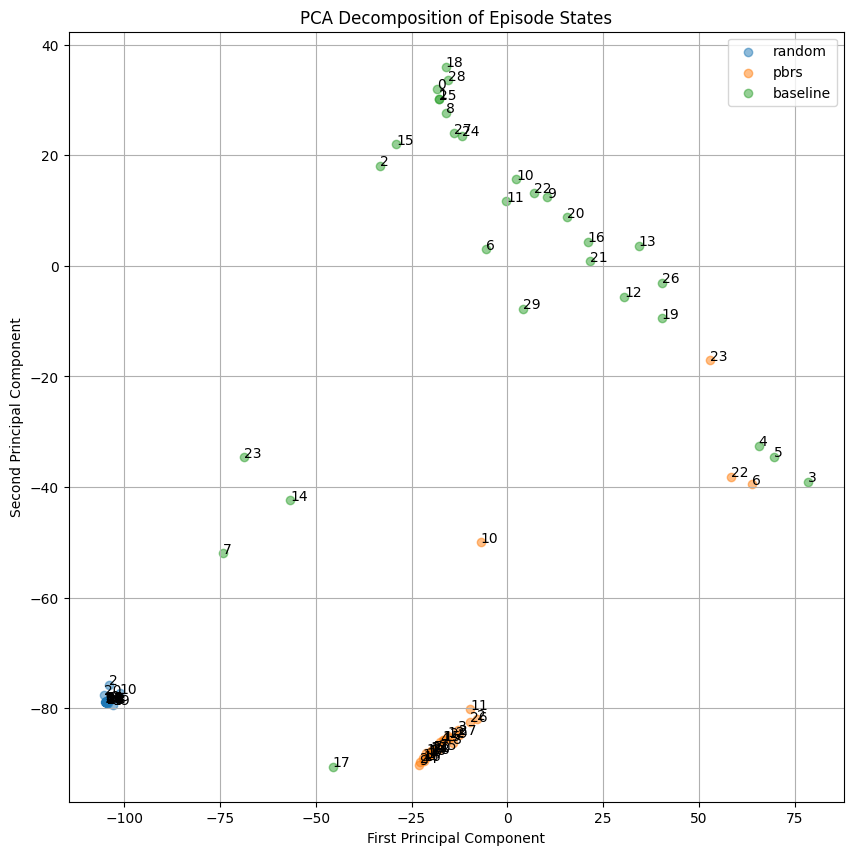

In [ ]:
import matplotlib.pyplot as plt

# -- TODO:
# - Regarder en quoi ces policies sont effectivement identiques ou non (longueur, gemmes, etc)
# - Essayer avec T-SNE

plt.figure(figsize=(10, 10))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Decomposition of Episode States')

for name, states in all_states.items():
    states_pca = pca.transform(states)
    plt.scatter(states_pca[:, 0], states_pca[:, 1], alpha=0.5, label=name)
    # Annotate each point with its ID
    for seed, state in enumerate(states_pca):
        plt.annotate(str(seed), (state[0], state[1]))


plt.grid(True)
plt.legend()
# plt.savefig("pca.png")
plt.show()

In [20]:
import marl 
import numpy as np


def get_runs_weights(logdir: str):
    exp = marl.Experiment.load(logdir)
    weights_by_run = dict[int, np.ndarray]()
    weights_list = []
    for i, run in enumerate(exp.runs):
        if i > 5:
            break
        run_weights = []
        for d in run.test_dirs:
            exp.agent.load(d)
            test_step_weights = []
            for network in exp.agent.networks:
                for name, params in network.named_parameters():
                    if "weight" in name:
                        w = params.detach().numpy().flatten()
                        test_step_weights.append(w)
            run_weights.append(np.concatenate(test_step_weights))
        run_weights = np.array(run_weights)
        weights_list.append(run_weights)
        weights_by_run[run.seed] = run_weights
        
    return np.array(weights_list)

In [22]:
import matplotlib.pyplot as plt
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
all_runs_weights = get_runs_weights("logs/pbrs-baseline")


print(all_runs_weights.shape)
pca.fit(all_runs_weights.reshape(-1, all_runs_weights.shape[-1]))

(6, 200, 235648)


PCA(n_components=2)

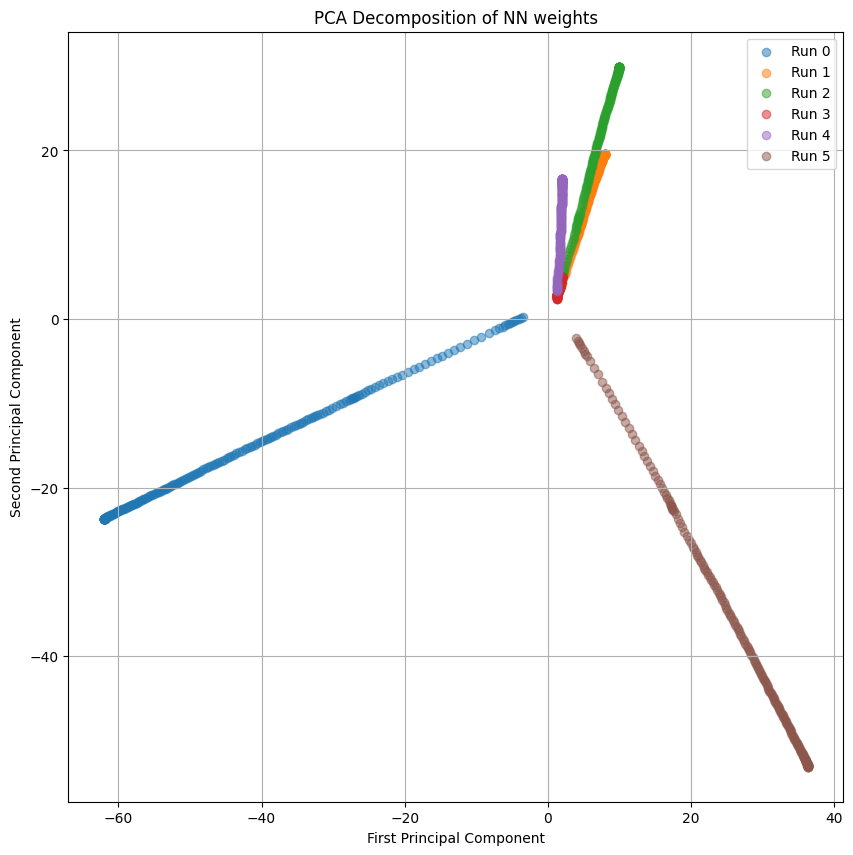

In [23]:
plt.figure(figsize=(10, 10))
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Decomposition of NN weights")


transform_by_run = {seed: pca.transform(weights) for seed, weights in enumerate(all_runs_weights)}
for seed, transformed in transform_by_run.items():
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, label=f"Run {seed}")
# plt.scatter(all_transformed[:, 0], all_transformed[:, 1], alpha=0.5)


plt.grid(True)
plt.legend()
# plt.savefig("pca.png")
plt.show()


# Cluster by distribution
We randomly sample the World states and compute the corresponding NN output.

In [2]:
from lle import World, WorldState
from itertools import product
import matplotlib.pyplot as plt
import numpy as np


def sample_world_states(world: World, n_samples: int) -> set[WorldState]:
    all_positions = set(product(range(world.height), range(world.width)))
    wall_pos = set(world.wall_pos)
    laser_pos = set(laser.pos for laser in world.lasers)
    valid_positions = list(all_positions - wall_pos - laser_pos)
    gems_pos = list(gem.pos for gem in world.gems)
    states = set[WorldState]()
    while len(states) < n_samples:
        indices = np.random.choice(np.arange(len(valid_positions)), world.n_agents, replace=False)
        positions = [valid_positions[i] for i in indices]
        gems_collected = [pos in positions for pos in gems_pos]
        state = WorldState(positions, gems_collected)
        # Check that the state is valid
        world.set_state(state)
        states.add(state)
    return states

100%|██████████| 10000/10000 [00:24<00:00, 403.69it/s]


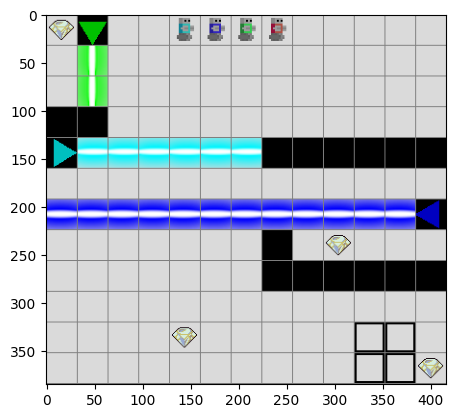

In [ ]:
import marl
from tqdm import tqdm
from lle import LLE
from marlenv.wrappers import RLEnvWrapper
from typing import Iterable
from torch import device

def get_qvalues(logdir: str, states: Iterable[WorldState], normalize: bool=False):
    exp = marl.Experiment.load(logdir)
    agent = exp.agent_at(1_000_000)#.to(device("cuda"))
    assert isinstance(agent, marl.agents.DQN)
    env = exp.env 
    assert isinstance(env, RLEnvWrapper)
    lle = env.unwrapped
    assert isinstance(lle, LLE)
    world = lle.world
    run_qvalues = []
    for state in tqdm(states):
        world.set_state(state)
        obs = env.get_observation()
        x = agent.qvalues(obs).numpy(force=True).flatten()
        run_qvalues.append(x)
    run_qvalues = np.array(run_qvalues)
    if normalize:
        run_qvalues = (run_qvalues - run_qvalues.mean(axis=-1)) / run_qvalues.std(axis=-1)
    return run_qvalues


In [ ]:
from lle import World 

logdirs = ["logs/pbrs-baseline", "logs/baseline-vdn"]
world = World.level(6)
plt.imshow(world.get_image())
states = sample_world_states(world, 10_000)

In [ ]:
normalized_qvalues = {logdir: get_qvalues(logdir, states, normalize=True) for logdir in logdirs}

In [ ]:
qvalues = {logdir: get_qvalues(logdir, states, normalize=False) for logdir in logdirs}

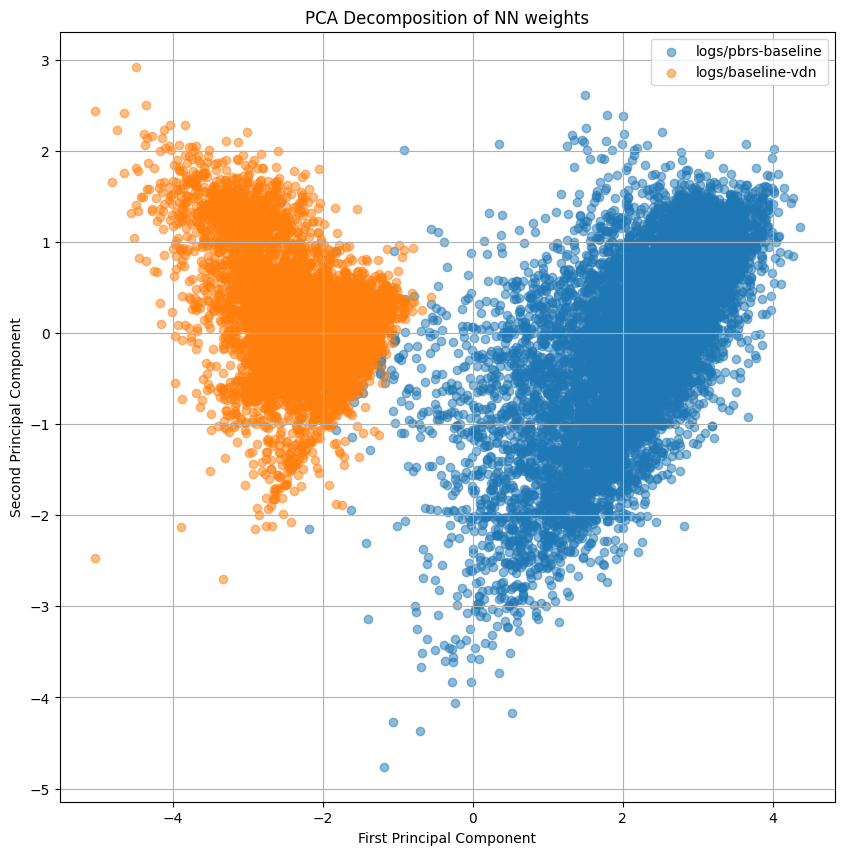

In [15]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)

pca.fit(qvalues)

plt.figure(figsize=(10, 10))
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Decomposition of NN weights")


transformed = pca.transform(qvalues)
for name, qvalues in qvalues_by_run.items():
    transformed = pca.transform(qvalues)
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, label=name)
# plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5)
# plt.scatter(all_transformed[:, 0], all_transformed[:, 1], alpha=0.5)


plt.grid(True)
plt.legend()
# plt.savefig("pca.png")
plt.show()

In [ ]:
This looks great and all but since the qvalues are on a very different scale, the separation is very easy
 -> Normalize the data on a per-run basis ?